

Analyse XGBOOST F1


Split: 50 train / 10 test

Performance metrics


Train set:
  RMSE: 5.1435 secondes
  MAE:  4.5202 secondes
  R²:   0.8617

Test set:
  RMSE: 5.6796 secondes
  MAE:  5.1615 secondes
  MAPE: 5.80%
  R²:   0.8572

Good: Acceptable Train-Test Discrepancy (0.005)




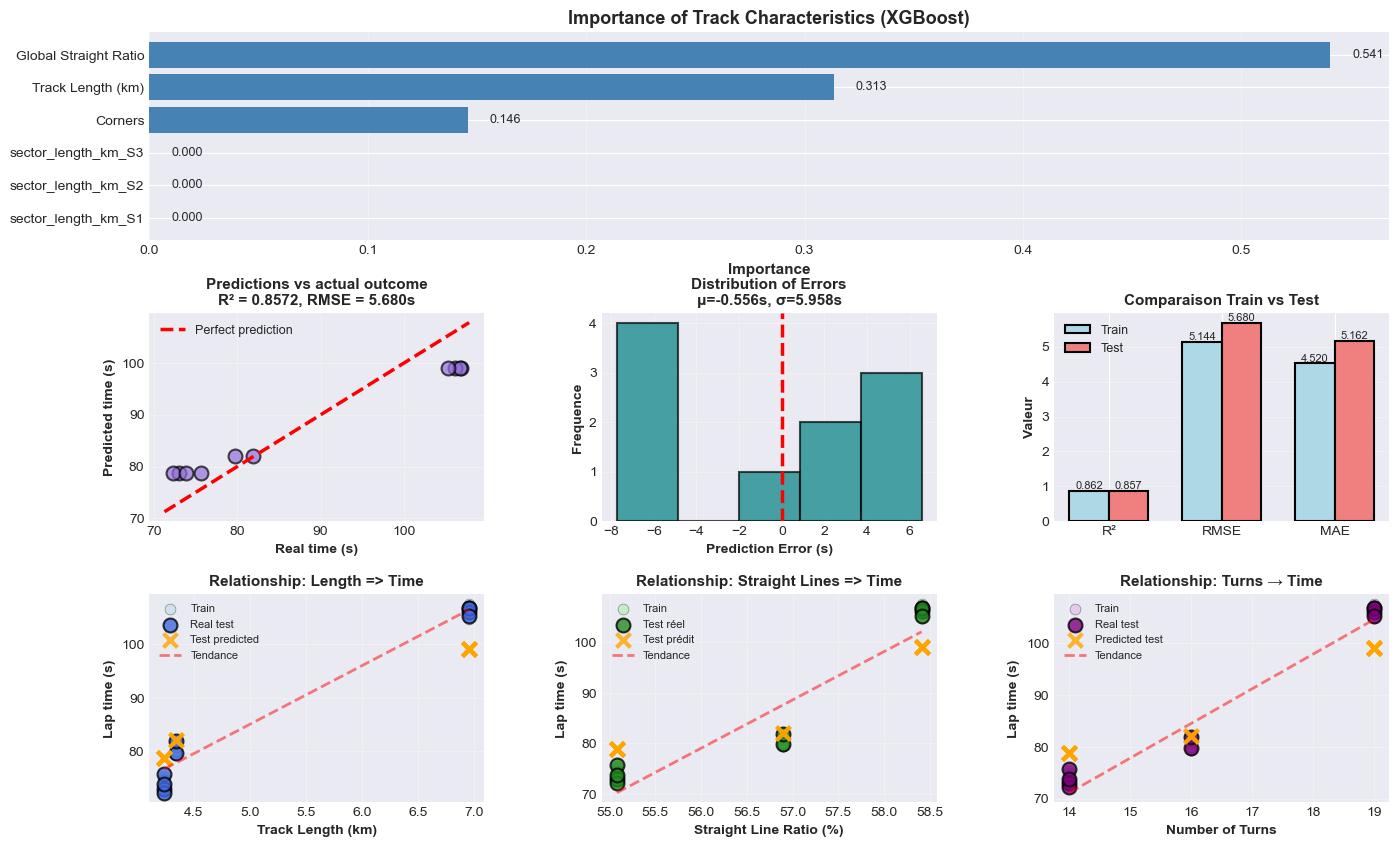


Relations analysis (XGBoost on 60 observations)

TOP 3 factors influencing lap time:
   1. Corners: 0.1459
   2. Track Length (km): 0.3135
   3. Global Straight Ratio: 0.5407

Observed trends:
Track length: +10.95s per additional km
Turn: +6.69s per additional turn
Straight lines: +9.56s per additional %
XGBOOST analysis finished


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("\n")
print("Analyse XGBOOST F1")
print("\n")

# Loading data
df = pd.read_csv('f1_grand_dataset_full.csv')


# Principales features
features = [
    'Track Length (km)',
    'Corners',
    'Global Straight Ratio',
    'sector_length_km_S1',
    'sector_length_km_S2',
    'sector_length_km_S3']


# Préparation X et y
X = df[features]
y = df['LapTime']

# Strategic split because we have a small dataset
test_size = max(0.15, min(0.25, 10/len(df)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=True)

print(f"Split: {len(X_train)} train / {len(X_test)} test")

# XGBOOST training

# Configuration to avoid overfitting
model = xgb.XGBRegressor(n_estimators=30,learning_rate=0.05,max_depth=2,min_child_weight=10,
    subsample=0.7,colsample_bytree=0.7,gamma=1.0,reg_alpha=2.0,reg_lambda=5.0,random_state=42)

model.fit(X_train, y_train)

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evalution

print(f"\nPerformance metrics")
print("\n")

# Train
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print(f"Train set:")
print(f"  RMSE: {rmse_train:.4f} secondes")
print(f"  MAE:  {mae_train:.4f} secondes")
print(f"  R²:   {r2_train:.4f}")

# Test
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print(f"\nTest set:")
print(f"  RMSE: {rmse_test:.4f} secondes")
print(f"  MAE:  {mae_test:.4f} secondes")
print(f"  MAPE: {mape_test:.2f}%")
print(f"  R²:   {r2_test:.4f}")

# Overfitting indicator
gap = r2_train - r2_test
if gap > 0.15:
    print(f"\nSignificant Train-Test Discrepancy ({gap:.3f}) => Possible overfitting")
elif gap < 0:
    print(f"\nGood: The model generalizes well (better test than train)")
else:
    print(f"\nGood: Acceptable Train-Test Discrepancy ({gap:.3f})")

print("\n")

# Visualitons
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)

# 1. important feature
ax1 = fig.add_subplot(gs[0, :])

importance_df = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=True)

bars = ax1.barh(importance_df['feature'], importance_df['importance'], color='steelblue')
ax1.set_xlabel('Importance', fontweight='bold', fontsize=11)
ax1.set_title('Importance of Track Characteristics (XGBoost)', fontweight='bold', fontsize=13)
ax1.grid(axis='x', alpha=0.3)

# Values ​​on the bars
for bar, val in zip(bars, importance_df['importance']):
    ax1.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{val:.3f}', va='center', fontsize=9)

# 2. Predictions and actual outcome

ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(y_test, y_pred_test, alpha=0.7, s=100, color='mediumpurple', 
           edgecolors='black', linewidth=1.5)
min_val = min(y_test.min(), y_pred_test.min()) - 1
max_val = max(y_test.max(), y_pred_test.max()) + 1
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2.5, label='Perfect prediction')
ax2.set_xlabel('Real time (s)', fontweight='bold', fontsize=10)
ax2.set_ylabel('Predicted time (s)', fontweight='bold', fontsize=10)
ax2.set_title(f'Predictions vs actual outcome\nR² = {r2_test:.4f}, RMSE = {rmse_test:.3f}s', 
             fontweight='bold', fontsize=11)
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)

# 3. Error distribution

ax3 = fig.add_subplot(gs[1, 1])
errors = y_pred_test - y_test
n_bins = min(10, len(y_test) // 2)
ax3.hist(errors, bins=n_bins, color='teal', alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.axvline(x=0, color='red', linestyle='--', linewidth=2.5)
ax3.set_xlabel('Prediction Error (s)', fontweight='bold', fontsize=10)
ax3.set_ylabel('Frequence', fontweight='bold', fontsize=10)
ax3.set_title(f'Distribution of Errors\nμ={errors.mean():.3f}s, σ={errors.std():.3f}s', 
             fontweight='bold', fontsize=11)
ax3.grid(alpha=0.3)

# 4. Overfitting check

ax4 = fig.add_subplot(gs[1, 2])
metrics = ['R²', 'RMSE', 'MAE']
train_vals = [r2_train, rmse_train, mae_train]
test_vals = [r2_test, rmse_test, mae_test]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax4.bar(x - width/2, train_vals, width, label='Train', color='lightblue', 
               edgecolor='black', linewidth=1.5)
bars2 = ax4.bar(x + width/2, test_vals, width, label='Test', color='lightcoral', 
               edgecolor='black', linewidth=1.5)

ax4.set_ylabel('Valeur', fontweight='bold', fontsize=10)
ax4.set_title('Comparaison Train vs Test', fontweight='bold', fontsize=11)
ax4.set_xticks(x)
ax4.set_xticklabels(metrics)
ax4.legend(fontsize=9)
ax4.grid(axis='y', alpha=0.3)

# Values ​​on the bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# Relations by feature
X_test_df = df.loc[X_test.index]
X_train_df = df.loc[X_train.index]

# Track Length
ax5 = fig.add_subplot(gs[2, 0])
ax5.scatter(X_train_df['Track Length (km)'], y_train, alpha=0.4, s=60, 
           color='lightblue', label='Train', edgecolors='black', linewidth=0.5)
ax5.scatter(X_test_df['Track Length (km)'], y_test, alpha=0.8, s=100,
           color='royalblue', label='Real test', edgecolors='black', linewidth=1.5)
ax5.scatter(X_test_df['Track Length (km)'], y_pred_test, alpha=0.8, s=100,
           color='orange', label='Test predicted', marker='x', linewidths=3)

# Trend line
z = np.polyfit(X_train_df['Track Length (km)'], y_train, 1)
p = np.poly1d(z)
x_line = np.linspace(X['Track Length (km)'].min(), X['Track Length (km)'].max(), 100)
ax5.plot(x_line, p(x_line), "r--", alpha=0.5, linewidth=2, label='Tendance')

ax5.set_xlabel('Track Length (km)', fontweight='bold', fontsize=10)
ax5.set_ylabel('Lap time (s)', fontweight='bold', fontsize=10)
ax5.set_title('Relationship: Length => Time', fontweight='bold', fontsize=11)
ax5.legend(fontsize=8)
ax5.grid(alpha=0.3)

# Global Straight Ratio
ax6 = fig.add_subplot(gs[2, 1])
ax6.scatter(X_train_df['Global Straight Ratio'], y_train, alpha=0.4, s=60,
           color='lightgreen', label='Train', edgecolors='black', linewidth=0.5)
ax6.scatter(X_test_df['Global Straight Ratio'], y_test, alpha=0.8, s=100,
           color='forestgreen', label='Test réel', edgecolors='black', linewidth=1.5)
ax6.scatter(X_test_df['Global Straight Ratio'], y_pred_test, alpha=0.8, s=100,
           color='orange', label='Test prédit', marker='x', linewidths=3)

# Trend line
z = np.polyfit(X_train_df['Global Straight Ratio'], y_train, 1)
p = np.poly1d(z)
x_line = np.linspace(X['Global Straight Ratio'].min(), X['Global Straight Ratio'].max(), 100)
ax6.plot(x_line, p(x_line), "r--", alpha=0.5, linewidth=2, label='Tendance')

ax6.set_xlabel('Straight Line Ratio (%)', fontweight='bold', fontsize=10)
ax6.set_ylabel('Lap time (s)', fontweight='bold', fontsize=10)
ax6.set_title('Relationship: Straight Lines => Time', fontweight='bold', fontsize=11)
ax6.legend(fontsize=8)
ax6.grid(alpha=0.3)

# Corners
ax7 = fig.add_subplot(gs[2, 2])
ax7.scatter(X_train_df['Corners'], y_train, alpha=0.4, s=60,
           color='plum', label='Train', edgecolors='black', linewidth=0.5)
ax7.scatter(X_test_df['Corners'], y_test, alpha=0.8, s=100,
           color='purple', label='Real test', edgecolors='black', linewidth=1.5)
ax7.scatter(X_test_df['Corners'], y_pred_test, alpha=0.8, s=100,
           color='orange', label='Predicted test', marker='x', linewidths=3)

# Ligne de tendance
z = np.polyfit(X_train_df['Corners'], y_train, 1)
p = np.poly1d(z)
x_line = np.linspace(X['Corners'].min(), X['Corners'].max(), 100)
ax7.plot(x_line, p(x_line), "r--", alpha=0.5, linewidth=2, label='Tendance')

ax7.set_xlabel('Number of Turns', fontweight='bold', fontsize=10)
ax7.set_ylabel('Lap time (s)', fontweight='bold', fontsize=10)
ax7.set_title('Relationship: Turns → Time', fontweight='bold', fontsize=11)
ax7.legend(fontsize=8)
ax7.grid(alpha=0.3)

plt.savefig('xgboost_f1_small_dataset.png', dpi=300, bbox_inches='tight')
plt.show()

# Relations analysis

print(f"\nRelations analysis (XGBoost on {len(df)} observations)")
print("="*60)

print(f"\nTOP 3 factors influencing lap time:")
for i, row in enumerate(importance_df.tail(3).iterrows(), 1):
    idx, data = row
    print(f"   {i}. {data['feature']}: {data['importance']:.4f}")

# Analyse des tendances
print(f"\nObserved trends:")

# Track Length
coef_length = np.polyfit(X_train_df['Track Length (km)'], y_train, 1)[0]
if coef_length > 0:
    print(f"Track length: +{coef_length:.2f}s per additional km")
else:
    print(f"Track length: {coef_length:.2f}s per additional km")

# Corners
coef_corners = np.polyfit(X_train_df['Corners'], y_train, 1)[0]
if coef_corners > 0:
    print(f"Turn: +{coef_corners:.2f}s per additional turn")
else:
    print(f"Turn: {coef_corners:.2f}s per additional turn")

# Straight Ratio
coef_straight = np.polyfit(X_train_df['Global Straight Ratio'], y_train, 1)[0]
if coef_straight < 0:
    print(f"Straight lines: {coef_straight:.2f}s per additional % (reduced time)")
else:
    print(f"Straight lines: +{coef_straight:.2f}s per additional %")


print(f"XGBOOST analysis finished")